In [137]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from tqdm.notebook import tqdm
import numpy as np
from numpy.typing import ArrayLike
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from skipper_image_analysis.utils import (
    correct_overscan, get_rowcol_ovserscan
)
from scipy.optimize import curve_fit
from scipy.stats import chi2
# from scipy.signal import peak_prominences, peak_widths


def intensidad_func(tph, tau, Pc):
    npump = 40000
    return npump*Pc*(np.exp(-tph/tau) - np.exp(-2*tph/tau))


def gaussiana(x, amplitud, mu, sigma):
    return amplitud * np.exp(-(x - mu)**2/(2*sigma**2))


def tau_func(T, e_kb, tau_0):
    return tau_0/(T**2)*np.exp(e_kb/T)


# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"


GANANCIA = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

CARPETAS_POR_TEMP: dict[str, list[str]] = {
    127: ["skipper_data/TRAPS/19NOV2023_127K/", "skipper_data/TRAPS/20NOV2023_127K/",],
    135: ["skipper_data/TRAPS/27NOV2023_135K/",],
    140: ["skipper_data/TRAPS/23NOV2023_140K/",],
    145: ["skipper_data/TRAPS/25NOV2023_145K/",],
    150: ["skipper_data/TRAPS/22NOV2023_150K/",],
    160: ["skipper_data/TRAPS/12DIC2023_160K/",],
    165: ["skipper_data/TRAPS/06DIC2023_165K/", "skipper_data/TRAPS/07DIC2023_165K/", "skipper_data/TRAPS/09DIC2023_165K/",],
}
RESULTS_DIR = "skipper_image_analysis/TRAPS_results"
CLOCKS_TO_SEC = 15e6  # Hz

In [138]:
def plot_region_con_margenes(
    main_ax_data: ArrayLike,
    x_margin_data: ArrayLike,
    y_margin_data: ArrayLike,
    main_ax_aspect=1,
) -> tuple[plt.Figure, plt.Axes, plt.Axes, plt.Axes]:
    # Create a Figure, which doesn't have to be square.
    fig = plt.figure(layout='constrained')
    # Create the main axes, leaving 25% of the figure space at the top and on the
    # right to position marginals.
    main_ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    # Create marginal axes, which have 25% of the size of the main axes.  Note that
    # the inset axes are positioned *outside* (on the right and the top) of the
    # main axes, by specifying axes coordinates greater than 1.  Axes coordinates
    # less than 0 would likewise specify positions on the left and the bottom of
    # the main axes.
    x_ax = main_ax.inset_axes([0, 1.0, 1, 0.25])
    x_ax.tick_params(axis='x', labelbottom=False, bottom=False)
    y_ax = main_ax.inset_axes([1.0, 0, 0.25, 1])
    y_ax.tick_params(axis='y', labelleft=False, left=False)
    # Draw the scatter plot and marginals.
    main_ax.imshow(
        main_ax_data,
        aspect=main_ax_aspect,
        origin='lower',
    )
    if x_margin_data.size == main_ax_data.shape[1]:
        x_ax.plot(np.arange(main_ax_data.shape[1]), x_margin_data)
        x_ax.sharex(main_ax)
    else:
        x_ax.plot(x_margin_data)
    if y_margin_data.size == main_ax_data.shape[0]:
        y_ax.plot(y_margin_data, np.arange(main_ax_data.shape[0]))
        y_ax.sharey(main_ax)
    else:
        y_ax.plot(y_margin_data, range(len(y_margin_data)))
    return fig, main_ax, x_ax, y_ax

skipper_data/TRAPS/27NOV2023_135K/proc_skp_pocket_oled1row_2film_dTph4800_NPUPMPS40000_NSAMP20_NROW879_NCOL336_EXPOSURE8.0_img281.fits


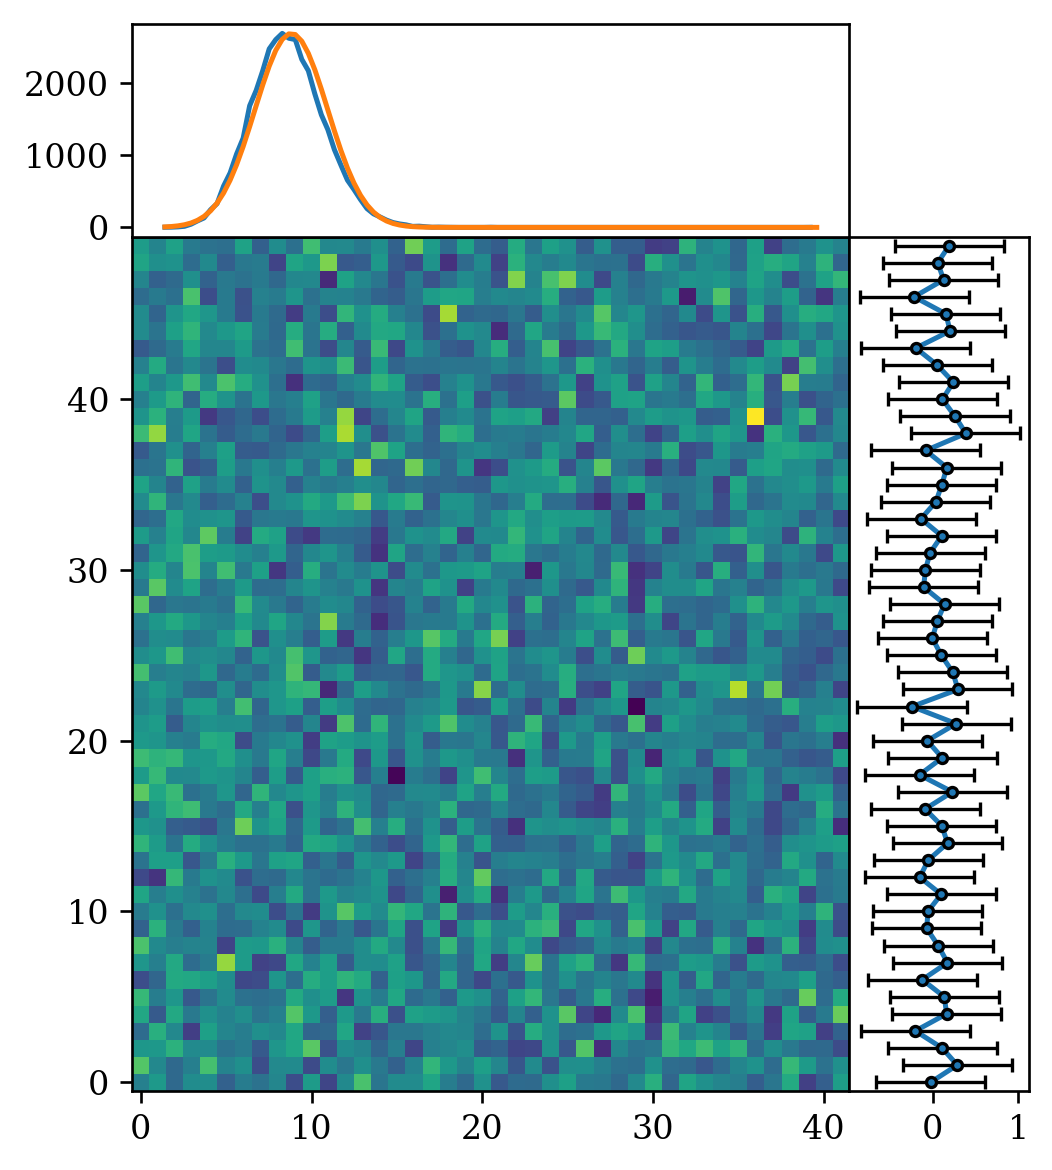

In [146]:
data_dir = CARPETAS_POR_TEMP[135][0]
files_in_dir = os.listdir(data_dir)
test_image = fits.open(f'{data_dir}/{files_in_dir[0]}')
print(data_dir, files_in_dir[0], sep="")
row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
test_frame = test_image[0]



# data = test_frame.data[1:-row_overscan_len, PRESCAN_PIX:-col_overscan_len]  # Área activa
overscan_data = test_frame.data[:, -col_overscan_len:]  # Overscan en columnas
overscan_data = overscan_data.copy()/GANANCIA[0]
error_lectura = np.std(overscan_data, ddof=1)
plot_data = overscan_data[200:250, :]

counts, edges = np.histogram(
        overscan_data, bins=100
    )
fig, main_ax, x_ax, y_ax = plot_region_con_margenes(
    plot_data,
    x_margin_data=counts,
    y_margin_data=plot_data.mean(axis=1),
    main_ax_aspect=1,
)
y_ax.errorbar(
    plot_data.mean(axis=1),
    np.arange(plot_data.shape[0]),
    xerr=error_lectura/np.sqrt(plot_data.shape[1]),
    fmt='.C0',
    markeredgecolor="k",
    ecolor='k',
    elinewidth=1,
    capsize=2,
)
x_ax.plot(
    gaussiana(
        edges,
        counts.max(),
        overscan_data.mean(),
        overscan_data.std(ddof=1)
    ),
)

plt.show()

In [148]:
def prepare_frame(
    skipper_image: fits.hdu.hdulist.HDUList,
    frame_idx: int,
    remove_row_median: bool = True,
) -> ArrayLike:
    global GANANCIA, PRESCAN_PIX
    r_overscan, c_overscan = get_rowcol_ovserscan(skipper_image)
    # Extract Read Error from Column Overscan
    overscan_frame = (
        skipper_image[frame_idx].data[:, -c_overscan:]
        / GANANCIA[frame_idx]
    )  # e⁻
    # Fit Gaussian to Column Overscan Distribution
    charge_frec, charge_bins = np.histogram(
        overscan_frame.flatten(),
        bins=np.linspace(
            overscan_frame.min(),
            np.min([overscan_frame.max(), -overscan_frame.min()]),
            500
        ),
        density=True,
    )
    try:  # Try to fit a Gaussian to the distribution
        popt, _ = curve_fit(
            gaussiana,
            charge_bins[:-1],
            charge_frec,
            p0=[1/np.sqrt(2*np.pi*4), 0, overscan_frame.std()],
        )
        error = np.abs(popt[2])  # e⁻
    except RuntimeError:  # If the fit fails, use the standard deviation and plot
        error = overscan_frame.std()  # e⁻
        # plt.plot(charge_bins[:-1], charge_frec, ".")
        # plt.plot(charge_bins[:-1], gaussiana(charge_bins[:-1], *popt))
        # plt.show()
    # Correct Baseline from Overscan in Rows and Columns
    skipper_image = correct_overscan(skipper_image)  # A.D.U.
    frame = skipper_image[frame_idx].data  # A.D.U.
    frame = frame[1:-r_overscan, PRESCAN_PIX:-c_overscan]  # A.D.U.
    if remove_row_median:
        # Remove the median of each row so that the median of the frame is zero
        frame = frame - np.median(frame, axis=1, keepdims=True)  # A.D.U.
    
    error_final = error * np.sqrt(
        1 + 1/r_overscan + 1/c_overscan + 1/frame.shape[1]
    )  # e⁻: Error propagado tras aplicar todas las correcciones
    return frame/GANANCIA[frame_idx], error_final # e⁻

In [150]:
def filtro_dipolos(
    frame: ArrayLike,
    threshold: float = 5e5,  # e⁻
    corte_simetria: float = 20,  # %
) -> tuple[list, list, ArrayLike]:  # ACTUALIZAR EN CÓDIGO!
    """Busca dipolos en un frame de la CCD. Para ello, se calcula el producto entre \
cada pixel y su vecino inferior. Si el producto es menor que un umbral negativo, se \
considera que hay un dipolo. Luego, se revisa que el dipolo sea simétrico, es decir, \
que los valores de los pixeles sean similares en magnitud. Si el dipolo es simétrico, \
se agrega a la lista de dipolos encontrados. Finalmente, se devuelve una lista con \
las coordenadas de los dipolos, una máscara con los dipolos encontrados y una lista \
con los valores de los dipolos.

    Parameters:
    -----------

        `frame {ArrayLike}`: Frame de la CCD a analizar. Debe estar en unidades de \
electrones.

        `threshold {float, optional}`: Valor umbral en la clasificación de picos. \
Valor por defecto = 500_000.

        `corte_simetria {float, optional}`: Defaults to 20.

    Returns:
    --------

        `{tuple[list, list, ArrayLike]}`:
    """
    prod_arr = frame[:-1] * frame[1:]
    val_trampas = []
    coordenadas_trampas = []
    mascara = np.zeros_like(frame)
    for j, col in enumerate(prod_arr.T):  # Recorro las columnas del frame
        for i, val in enumerate(col):  # Recorro los valores de cada columna
            if val < -threshold:
                # Reviso que no esté en el borde del frame
                if i == 0:
                    i_lleno = np.argmax(frame[i:i+2, j])
                    i_lleno = i_lleno + i - 1
                    i_vacio = np.argmin(frame[i:i+2, j])
                    i_vacio = i_vacio + i - 1
                elif i == len(col):
                    i_lleno = np.argmax(frame[i-1:i+1, j])
                    i_lleno = i_lleno + i - 1
                    i_vacio = np.argmin(frame[i-1:i+1, j])
                    i_vacio = i_vacio + i - 1
                else:
                    i_lleno = np.argmax(frame[i-1:i+2, j])
                    i_lleno = i_lleno + i - 1
                    i_vacio = np.argmin(frame[i-1:i+2, j])
                    i_vacio = i_vacio + i - 1
                if np.abs(i_lleno-i_vacio) == 1:  # Confirmo adyacencia
                    val_1  = frame[i_lleno, j]
                    val_2 = frame[i_vacio, j]
                    diferencia_relativa = np.abs(
                        100
                        * (np.abs(val_1) - np.abs(val_2))
                        / np.max([np.abs(val_1), np.abs(val_2)])
                    )
                    if diferencia_relativa < corte_simetria:  # filtro por simetría
                        coordenadas_trampas.append(((i_lleno, j), (i_vacio, j)))
                        val_trampas.append(np.abs(val_1 - val_2) / 2)
                        mascara[i_lleno, j] = 1
                        mascara[i_vacio, j] = 1
    return coordenadas_trampas, val_trampas, mascara

In [151]:
def carga_archivos(
    temperatura: int, dir_idx: int, frame_idx: int,
    threshold: float = 5e5, corte_simetria: float = 20
) -> tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]:
    """Carga los archivos de una carpeta de una temperatura y un número de archivo \
específicos. Luego, aplica el filtro de dipolos a cada frame y devuelve las \
coordenadas de los dipolos, los valores de los dipolos, una máscara con los dipolos \
encontrados, el objeto fits con los datos de la CCD en la última imagen procesada y \
un diccionario con los errores de cada frame.

    Parameters:
    -----------

        `temperatura {int}`: Temperatura de la CCD en Kelvin durante la toma de datos.

        `dir_idx {int}`: Índice de la carpeta con los archivos a cargar cuando existe \
más de una carpeta por temperatura.

        `frame_idx {int}`: Índice del frame/cuadrante de la CCD a analizar.

        `threshold {float, optional}`: Umbrál en (e⁻)² para la detección de dipolos. \
Valor por defecto = 500_000.

        `corte_simetria {float, optional}`: Porcentaje de la diferencia en simetría \
para el filtro en la detección de dipolos. Valor por defecto = 20.

    Returns:
    --------

        `{tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]}`: Diccionarios\
 con las coordenadas de los dipolos, los valores de los dipolos, una máscara con los \
dipolos encontrados, el objeto fits con los datos de la CCD en la última imagen y un \
diccionario con los errores de cada frame.
    """
    global CARPETAS_POR_TEMP
    # Cargar Archivos desde sus Carpetas por Temperatura
    data_dir = CARPETAS_POR_TEMP[temperatura][dir_idx]
    files_in_dir = os.listdir(data_dir)
    valid_formats = ["fits",]
    files_in_dir = [f for f in files_in_dir if f.rsplit(".")[-1] in valid_formats]
    frames_dict = dict()
    error_dict = dict()
    coords_dict = dict()
    vals_dict = dict()
    mascara_dipolos = dict()
    for file in tqdm(files_in_dir, desc="Procesando Archivos"):
        dtph = int(file.rsplit("_")[5][4:])
        if dtph in coords_dict:
            continue
        test_image = fits.open(f'{data_dir}/{file}')
        frames_dict[dtph], error_dict[dtph] = prepare_frame(test_image, frame_idx)  # e⁻
        if error_dict[dtph] > 1e3:  # Si el error es muy grande, descartar el frame
            # Por el NSAMP=20 sabemos que el error de lectura es del orden de 10 e⁻
            del frames_dict[dtph], error_dict[dtph]
            continue
        coords_dict[dtph], vals_dict[dtph], mascara_dipolos[dtph] = filtro_dipolos(
            frames_dict[dtph], threshold, corte_simetria
        )
        # Transform relative coords (of frame) to absolute coords (of CCD)
        coords_dict[dtph] = [
            (
                (coords[0][0], coords[0][1] + PRESCAN_PIX),
                (coords[1][0], coords[1][1] + PRESCAN_PIX),
            )
            for coords in coords_dict[dtph]
        ]
    return coords_dict, frames_dict, vals_dict, error_dict, mascara_dipolos, test_image

In [ ]:
def frame_coords_to_ccd_coords(
    coord: tuple[int, int], frame_idx: int, CCDNROWS: int, CCDNCOLS: int
) -> tuple[int, int]:
    """Transforma las coordenadas relativas a un frame a las coordenadas de la \
CCD considerando el frame, el prescan y el overscan.
    """
    x, y = coord
    fila = y 
    # TO DO

In [ ]:
def identificacion_e_intensidad(coords_dict, frames_dict):
    """Identifica trampas en todos los dtph y busca la intensidad
    de cada trampa en todos los dtph"""
    trampas_halladas = []
    intensidad_por_trampa = []
    dtph_vals = list(coords_dict.keys())
    dtph_vals = [dtph_vals[i] for i in np.argsort(dtph_vals)]
    for dtph in tqdm(
        dtph_vals[::-1],
        desc="Recorriendo dTph",
        total=len(dtph_vals),
    ):
        coordenadas_trampas = coords_dict[dtph]
        for coords in coordenadas_trampas:
            if coords in trampas_halladas:
                continue
            trampas_halladas.append(coords)
            intensidades_trampa = []
            for dtph_frames in dtph_vals:
                frame = frames_dict[dtph_frames]
                intensidades_trampa.append(np.abs(frame[coords[0]]-frame[coords[1]])/2)
            intensidad_por_trampa.append(intensidades_trampa)
    return trampas_halladas, intensidad_por_trampa, dtph_vals